In [3]:
import numpy as np

from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau
)
from keras.layers import (
    Rescaling,
    Flatten,
    Dense,
)
from keras.applications import VGG16

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

import common as cmn


In [4]:
prePath = "../Data/PreprocessedResNet"

shape = (224, 224, 3)
batchSize = 32
validationSplit = 0.2
seed = 123
colorMode = "rgb"

learningRate = 0.00005
LRReductionFactor = 0.2
minimumLR = 0.01 * learningRate

earlyStoppingPatience = 15
LRReductionPatience = 1

epochs = 100

In [5]:
trainingDS = image_dataset_from_directory(
    prePath,
    labels="inferred",
    label_mode="binary",
    subset="training",
    image_size=shape[0:2],
    color_mode=colorMode,
    batch_size=batchSize,    
    validation_split=validationSplit,
    seed=seed
)

validationDS = image_dataset_from_directory(
    prePath,
    labels="inferred",
    label_mode="binary",
    subset="validation",
    image_size=shape[0:2],
    color_mode=colorMode,
    batch_size=batchSize,    
    validation_split=validationSplit,
    seed=seed
)

sampleSize = sum([fi[1] for fi in cmn.get_folder_info(prePath)])
testDSBatchNumber = int(sampleSize // batchSize * (validationSplit / 2))

testDS = validationDS.take(testDSBatchNumber)
validationDS = validationDS.skip(testDSBatchNumber)

Found 1696 files belonging to 2 classes.
Using 1357 files for training.
Found 1696 files belonging to 2 classes.
Using 339 files for validation.


In [6]:
callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=earlyStoppingPatience,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=LRReductionFactor,
        patience=LRReductionPatience,
        verbose=1,
        mode="auto",
        min_lr=minimumLR
    )]

pretrainedModel = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=shape
)
for l in pretrainedModel.layers:
    l.trainable = False

model = Sequential(
    [
        Rescaling(1.0 / 255, input_shape=shape),
        pretrainedModel,
        Flatten(),
        Dense(units=1024, activation="ReLU"),
        Dense(units=1024, activation="ReLU"),
        Dense(units=1, activation="sigmoid"),
    ])

pretrainedModel.summary()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
optimizer = Adam(learning_rate=learningRate)
loss = "binary_crossentropy"
metrics = ["accuracy"]

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)
history = model.fit(
    trainingDS,
    validation_data=validationDS,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
43/43 [==============================] - 562s 13s/step - loss: 0.6647 - accuracy: 0.5925 - val_loss: 0.6221 - val_accuracy: 0.5698 - lr: 5.0000e-05
Epoch 2/100
43/43 [==============================] - 781s 18s/step - loss: 0.5807 - accuracy: 0.6868 - val_loss: 0.5002 - val_accuracy: 0.7709 - lr: 5.0000e-05
Epoch 3/100
43/43 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.7237
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
43/43 [==============================] - 464s 11s/step - loss: 0.5215 - accuracy: 0.7237 - val_loss: 0.6713 - val_accuracy: 0.6480 - lr: 5.0000e-05
Epoch 4/100
43/43 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.7583 
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
43/43 [==============================] - 497s 12s/step - loss: 0.4828 - accuracy: 0.7583 - val_loss: 0.5221 - val_accuracy: 0.7151 - lr: 1.0000e-05
Epoch 5/100
43/43 [=====================

In [9]:
trueArray = np.concatenate([y for x, y in testDS], axis=0).ravel()

predictions = model.predict(testDS)

predArray = np.array((1 * (predictions > 0.5))).ravel()

print(f"True values:      {trueArray}")
print(f"Predicted values: {predArray}")

5/5 [==============================] - 57s 11s/step
True values:      [0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
Predicted values: [1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1
 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0
 0 0 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1
 0 1 0 0 0 0 1 1 1 0 0 1]


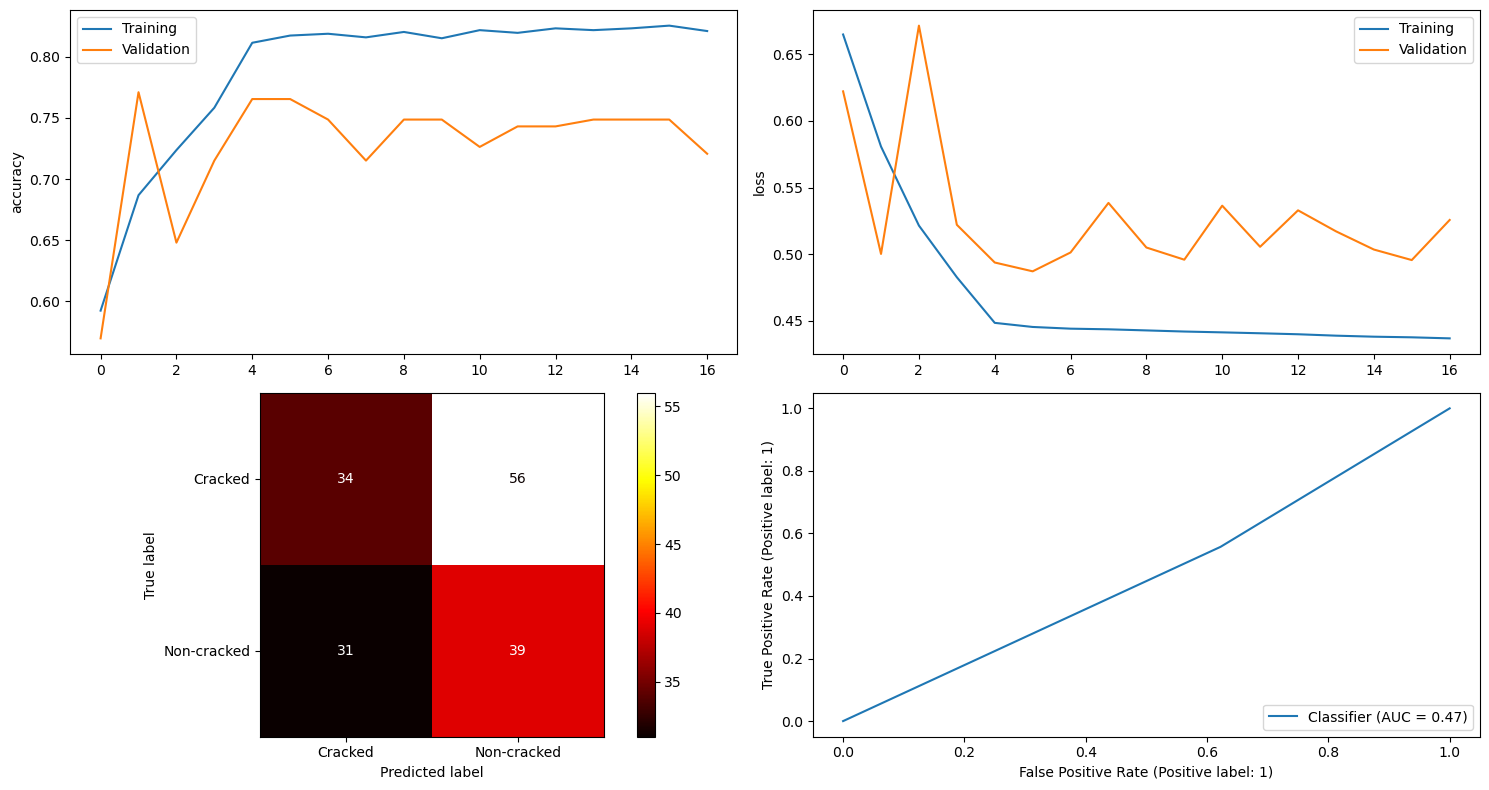

In [11]:
epochsTaken = len(history.history["accuracy"])

_, ax = plt.subplots(2, 2, figsize=(15, 8), tight_layout=True)
sns.lineplot(
    x=np.arange(epochsTaken),
    y="accuracy",
    data=history.history,
    ax=ax[0, 0],
    label="Training",
)
sns.lineplot(
    x=np.arange(epochsTaken),
    y="val_accuracy",
    data=history.history,
    ax=ax[0, 0],
    label="Validation",
)
sns.lineplot(
    x=np.arange(epochsTaken),
    y="loss",
    data=history.history,
    ax=ax[0, 1],
    label="Training",
)
sns.lineplot(
    x=np.arange(epochsTaken),
    y="val_loss",
    data=history.history,
    ax=ax[0, 1],
    label="Validation",
)
ConfusionMatrixDisplay.from_predictions(
            trueArray,
            predArray,
            display_labels=trainingDS.class_names,
            ax=ax[1, 0],
            cmap="hot",
            colorbar=True,
)
RocCurveDisplay.from_predictions(
    trueArray,
    predArray,
    ax=ax[1, 1])
       
plt.show()


In [25]:
tunedLR = 0.00005
tunedLRRedFactor = 0.2
tunedMinLR = 0.01 * learningRate

tunedCallbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=earlyStoppingPatience,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=tunedLRRedFactor,
        patience=LRReductionPatience,
        verbose=1,
        mode="auto",
        min_lr=tunedMinLR
    )]

trainablePreModel = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=shape
)
for l in trainablePreModel.layers:
    l.trainable = True

tunedModel = Sequential(
    [
        Rescaling(1.0 / 255, input_shape=shape),
        trainablePreModel,
        Flatten(),
        Dense(units=1024, activation="ReLU"),
        Dense(units=1024, activation="ReLU"),
        Dense(units=1, activation="sigmoid"),
    ])
tunedModel.set_weights(model.get_weights())

trainablePreModel.summary()
tunedModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
optimizer = Adam(learning_rate=tunedLR)
loss = "binary_crossentropy"
metrics = ["accuracy"]

tunedModel.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)
tunedHistory = tunedModel.fit(
    trainingDS,
    validation_data=validationDS,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
43/43 [==============================] - 2691s 62s/step - loss: 0.5959 - accuracy: 0.6846 - val_loss: 0.5513 - val_accuracy: 0.7877 - lr: 5.0000e-05
Epoch 2/100
43/43 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.7826  
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
43/43 [==============================] - 2748s 64s/step - loss: 0.4635 - accuracy: 0.7826 - val_loss: 0.5426 - val_accuracy: 0.7598 - lr: 5.0000e-05
Epoch 3/100
43/43 [==============================] - 2787s 65s/step - loss: 0.3290 - accuracy: 0.8563 - val_loss: 0.3986 - val_accuracy: 0.8101 - lr: 1.0000e-05
Epoch 4/100
43/43 [==============================] - 2493s 58s/step - loss: 0.2771 - accuracy: 0.8873 - val_loss: 0.3972 - val_accuracy: 0.8156 - lr: 1.0000e-05
Epoch 5/100
43/43 [==============================] - 2651s 62s/step - loss: 0.2296 - accuracy: 0.9123 - val_loss: 0.4358 - val_accuracy: 0.8492 - lr: 1.0000e-05
Epoch 6/100
43/43 [===============

KeyboardInterrupt: 

In [27]:
tunedTrueArray = np.concatenate([y for x, y in testDS], axis=0).ravel()

tunedPredictions = tunedModel.predict(testDS)

tunedPredArray = np.array((1 * (tunedPredictions > 0.5))).ravel()

print(f"True values:      {tunedTrueArray}")
print(f"Predicted values: {tunedPredArray}")

5/5 [==============================] - 123s 26s/step
True values:      [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
Predicted values: [0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0
 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1
 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1
 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 1 0]


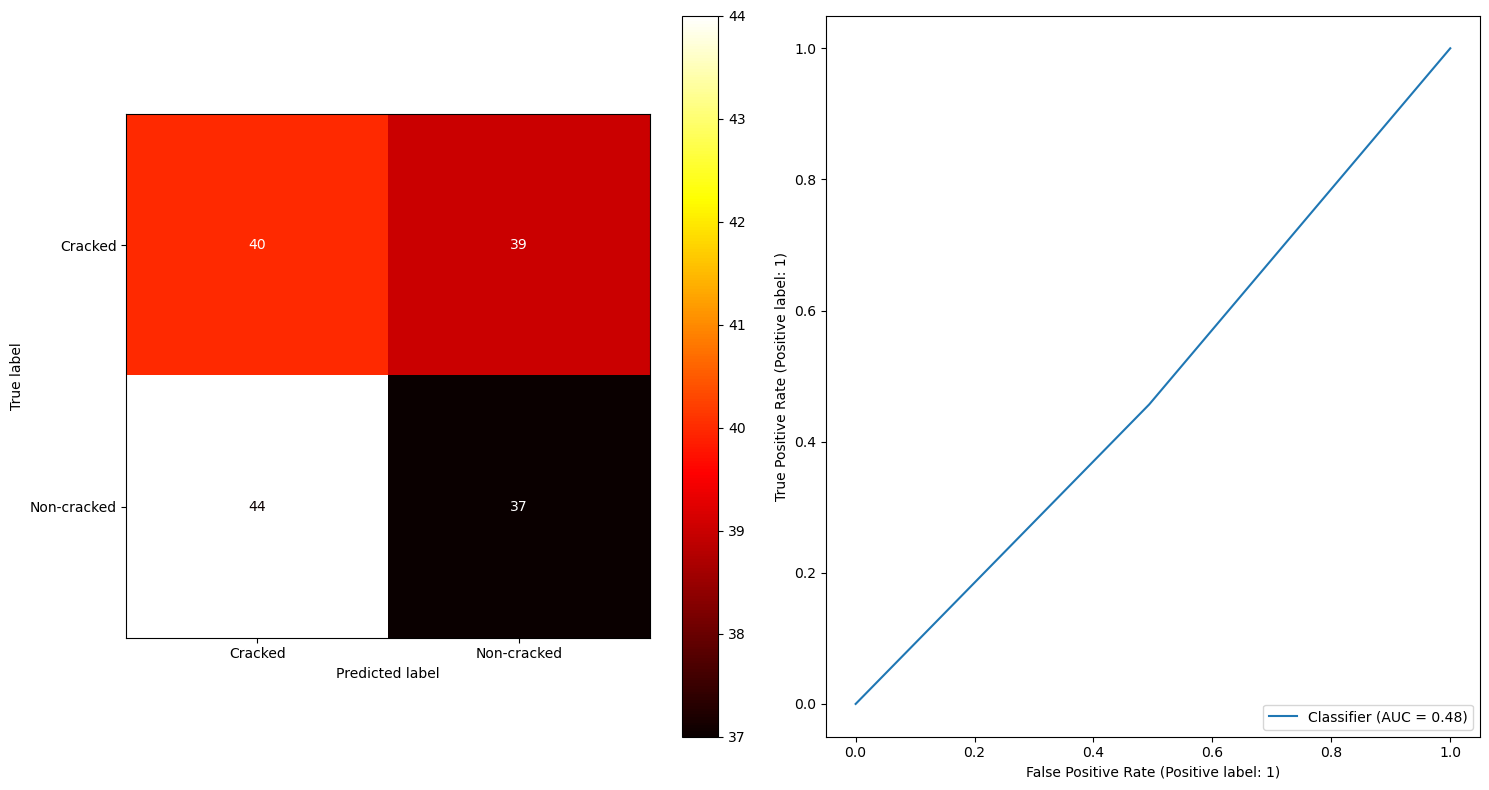

In [39]:
# epochsTaken = len(tunedHistory.history["accuracy"])

_, ax = plt.subplots(1, 2, figsize=(15, 8), tight_layout=True)
# sns.lineplot(
#     x=np.arange(epochsTaken),
#     y="accuracy",
#     data=tunedHistory.history,
#     ax=ax[0, 0],
#     label="Training",
# )
# sns.lineplot(
#     x=np.arange(epochsTaken),
#     y="val_accuracy",
#     data=tunedHistory.history,
#     ax=ax[0, 0],
#     label="Validation",
# )
# sns.lineplot(
#     x=np.arange(epochsTaken),
#     y="loss",
#     data=tunedHistory.history,
#     ax=ax[0, 1],
#     label="Training",
# )
# sns.lineplot(
#     x=np.arange(epochsTaken),
#     y="val_loss",
#     data=tunedHistory.history,
#     ax=ax[0, 1],
#     label="Validation",
# )
ConfusionMatrixDisplay.from_predictions(
            tunedTrueArray,
            tunedPredArray,
            display_labels=trainingDS.class_names,
            ax=ax[0],
            cmap="hot",
            colorbar=True,
)
RocCurveDisplay.from_predictions(
    tunedTrueArray,
    tunedPredArray,
    ax=ax[1])
       
plt.show()